In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook
plt.style.use('ggplot')

# TP n°2 : Support Vector Machine (SVM) - Benjamin Cohen

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

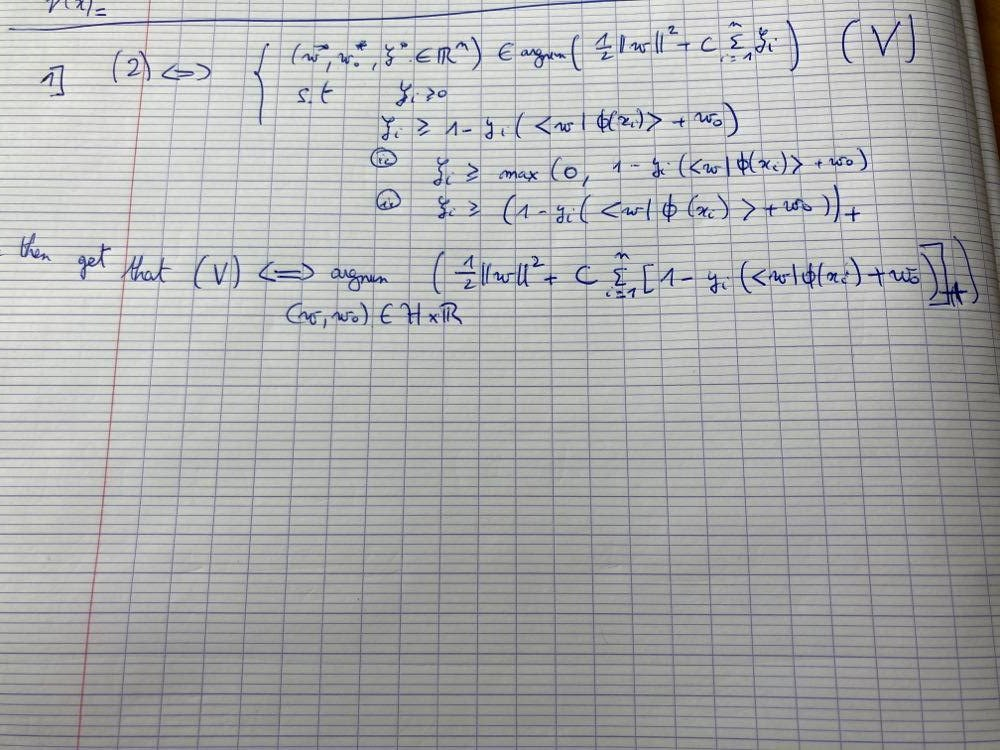

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

An SVM uses a convex error function. Our purpose is to minimize that function with respect to each parameter. Any local minimum of a convex function is also a global minimum it helps us avoiding stopping the algorithm on a local minimum which would be no help in minimizing our loss function.

The difference between the pivotal loss and binary loss are the fact that when  1−𝑦𝑖(⟨𝐰,Φ(𝐱𝐢)⟩+𝑤0)  is positive, the binary loss will return  1  whereas the hinge loss will return the actual value of the loss. 
We can write that 𝐵𝑖𝑛𝑎𝑟𝑦𝐿𝑜𝑠𝑠(𝑧)=𝑠𝑔𝑛(𝐻𝑖𝑛𝑔𝑒𝐿𝑜𝑠𝑠(𝑧)−1) .

## Example of using SVC (originally in ```svm_script.py```)

In [2]:
from matplotlib import rc
from matplotlib.colors import ListedColormap
import seaborn as sns

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
# text.usetex is set as False by default to avoid problems with student computers
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

###############################################################################
#           Displaying labeled data
###############################################################################

symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=[color_blind_list[i]], s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
              samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec.reshape(1, -1)) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

<IPython.core.display.Javascript object>


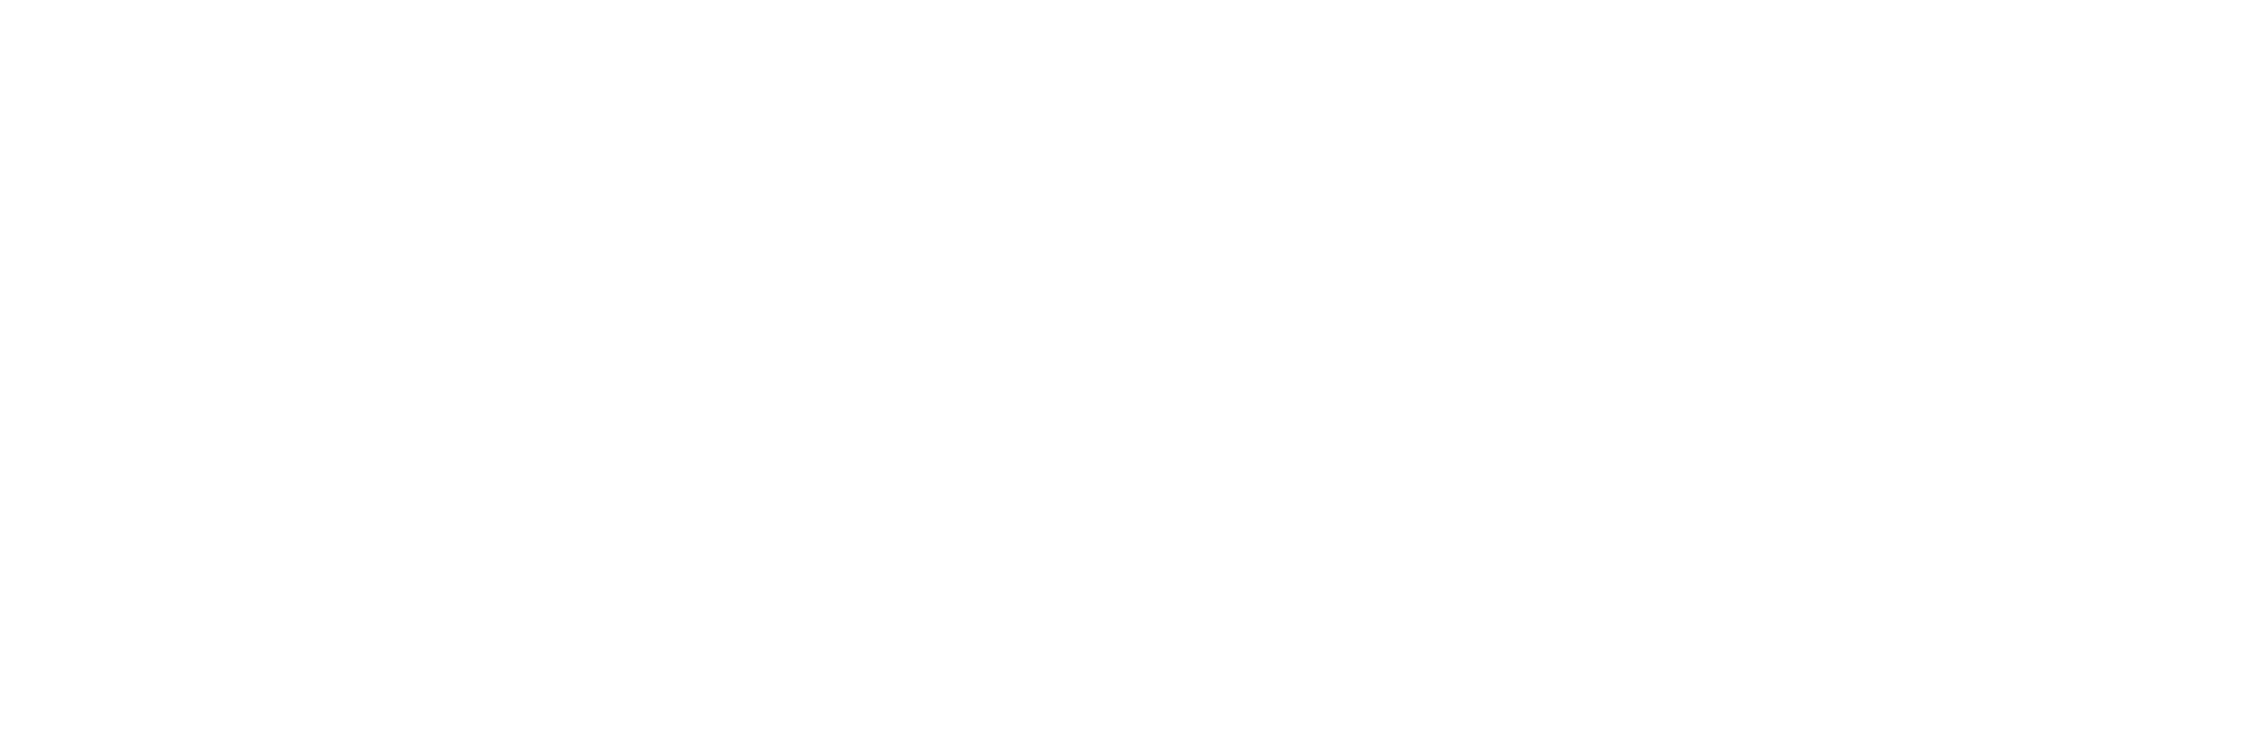

Score : 0.95


<IPython.core.display.Javascript object>


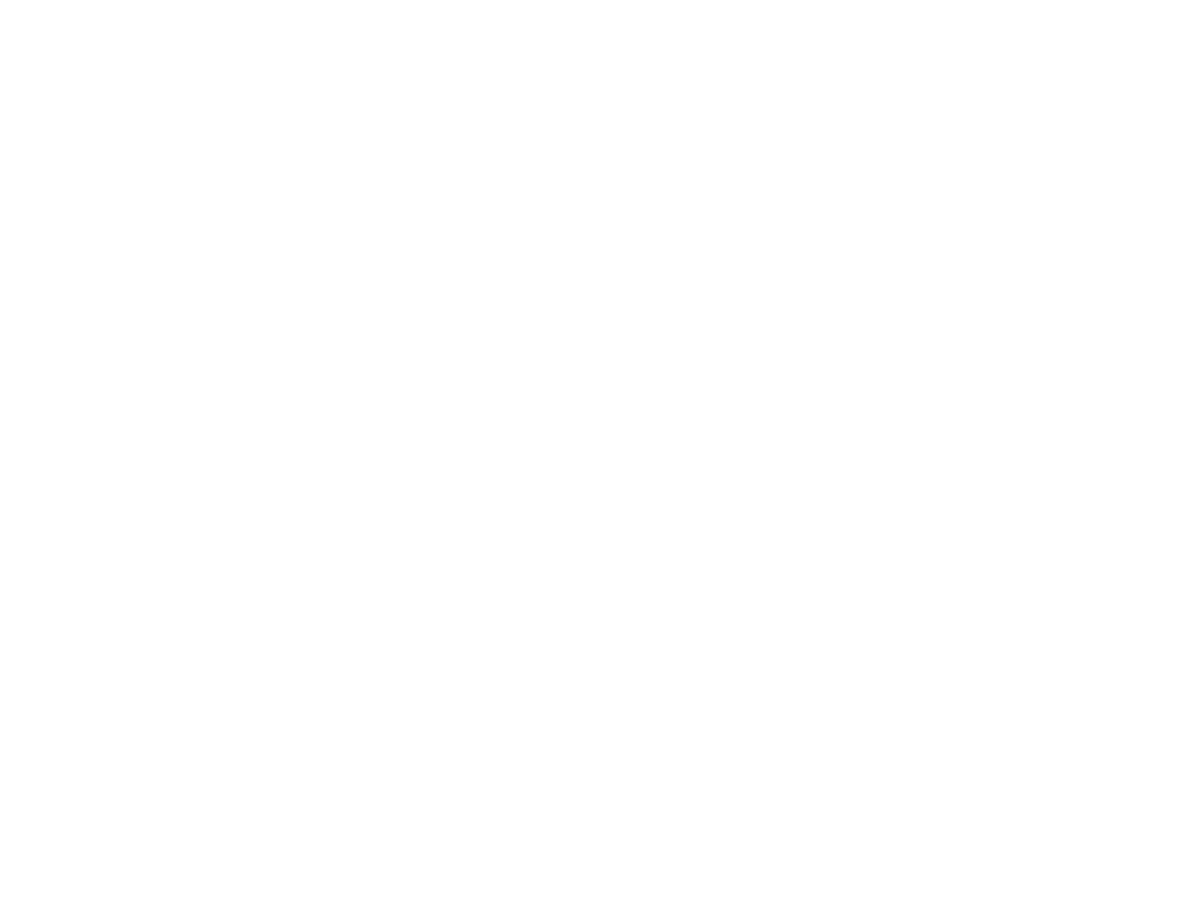

In [3]:
# This is an example of using SVC for data generated in the same way as the previous TP
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.title('First data set')
plot_2d(X1, y1)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score = clf.score(X_test, Y_test)
print('Score : %s' % score)
# display the frontiere


def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return clf.predict(xx.reshape(1, -1))

plt.figure(2)
frontiere(f, X_train, Y_train, w=None, step=50, alpha_choice=1)

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distrtibutions : each class is a Gaussian with specific parameters. This time, use the function make_blobs available in sklearn.datasets library. Reserve 75% of the data for training and 25% for the test data.

<IPython.core.display.Javascript object>


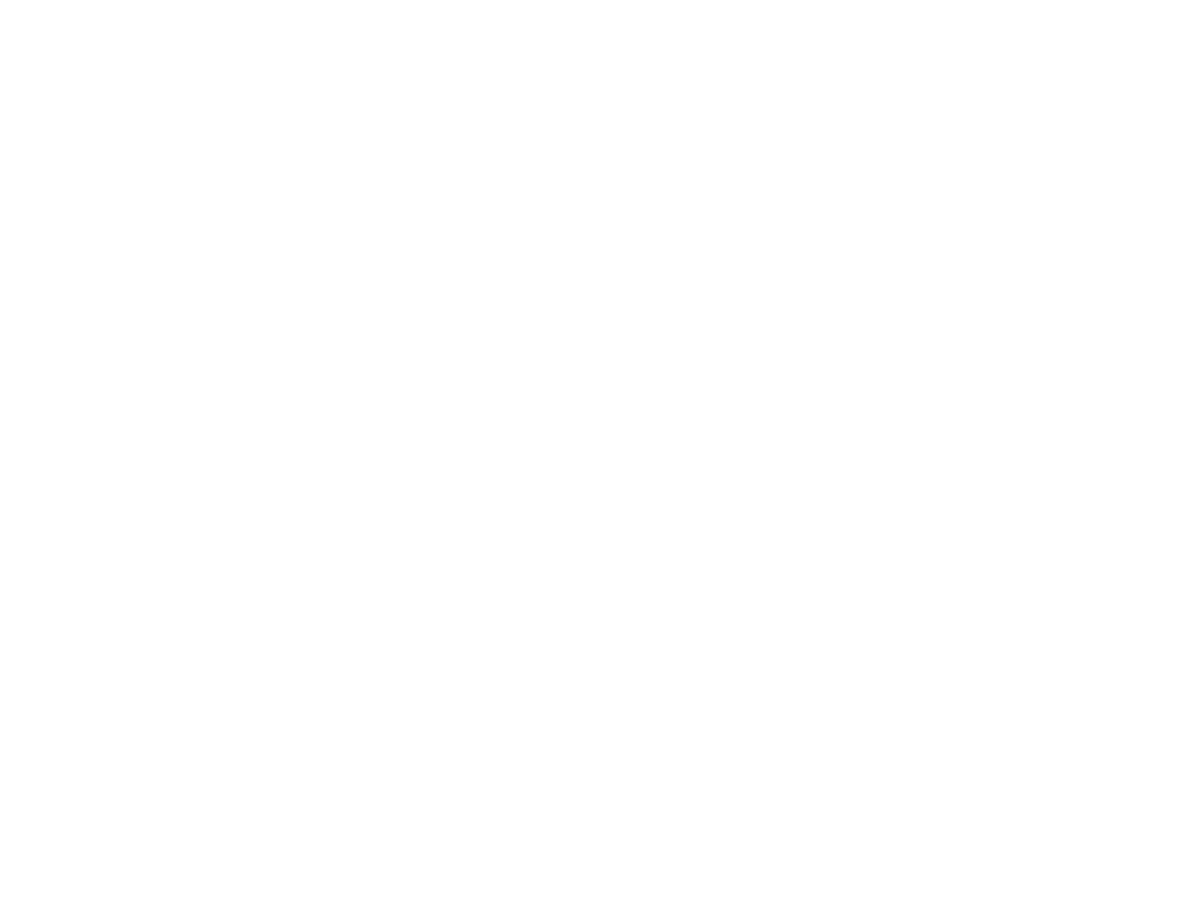

In [4]:
plt.close()
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000,centers = 2 ,random_state=0)
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
figure, axis = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=axis, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

In [5]:
# Split X and Y into training and testing datasets
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.25)

# Ensure training dataset has only 75% of original X data
print(train_X.shape[0] / X.shape[0])

# Ensure testing dataset has only 25% of original X data
print(test_X.shape[0] / X.shape[0])

0.75
0.25


**4)** Since the probability distributions are known, numerically estimate the Bayes risk.

In [6]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)

n= 1000
mu = [[X[:,0].mean(),X[:,1].mean()], [y[:,].mean(),y[:,].mean()]]

mc_0 = np.random.multivariate_normal(mu[0], np.eye(2), n//2)
mc_1 = np.random.multivariate_normal(mu[1], np.eye(2), n//2)
MC = np.concatenate((mc_0,mc_1), axis = 0)

bayes_mean = 0 
for c in MC:
    prob_0 = multivariate_normal.pdf(c, mu[0], cov=np.eye(2))
    prob_1 = multivariate_normal.pdf(c, mu[1], cov=np.eye(2))
    bayes_risk = min(prob_0/(prob_0+prob_1), prob_1/(prob_0+prob_1))
    bayes_mean += (1/n)*bayes_risk
    
print('Estimation of the Bayes Risk =', bayes_mean)

Estimation of the Bayes Risk = 0.12609745876093306


Notons que lorsque les points s'écartent on a bien une réduction du risque de Bayes.

**5)** Draw the decision boundary H induced by SVM as well as the hyperplanes H1 and H−1. Vary the parameter C to see its impact on the number of support vectors. We can use the example https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

In [7]:
plt.close()
# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear',C=1000)
clf.fit(train_X, train_Y)
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
plt.show()

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation to find the optimal parameter C∗ to classify this new dataset using a linear kernel.

<IPython.core.display.Javascript object>


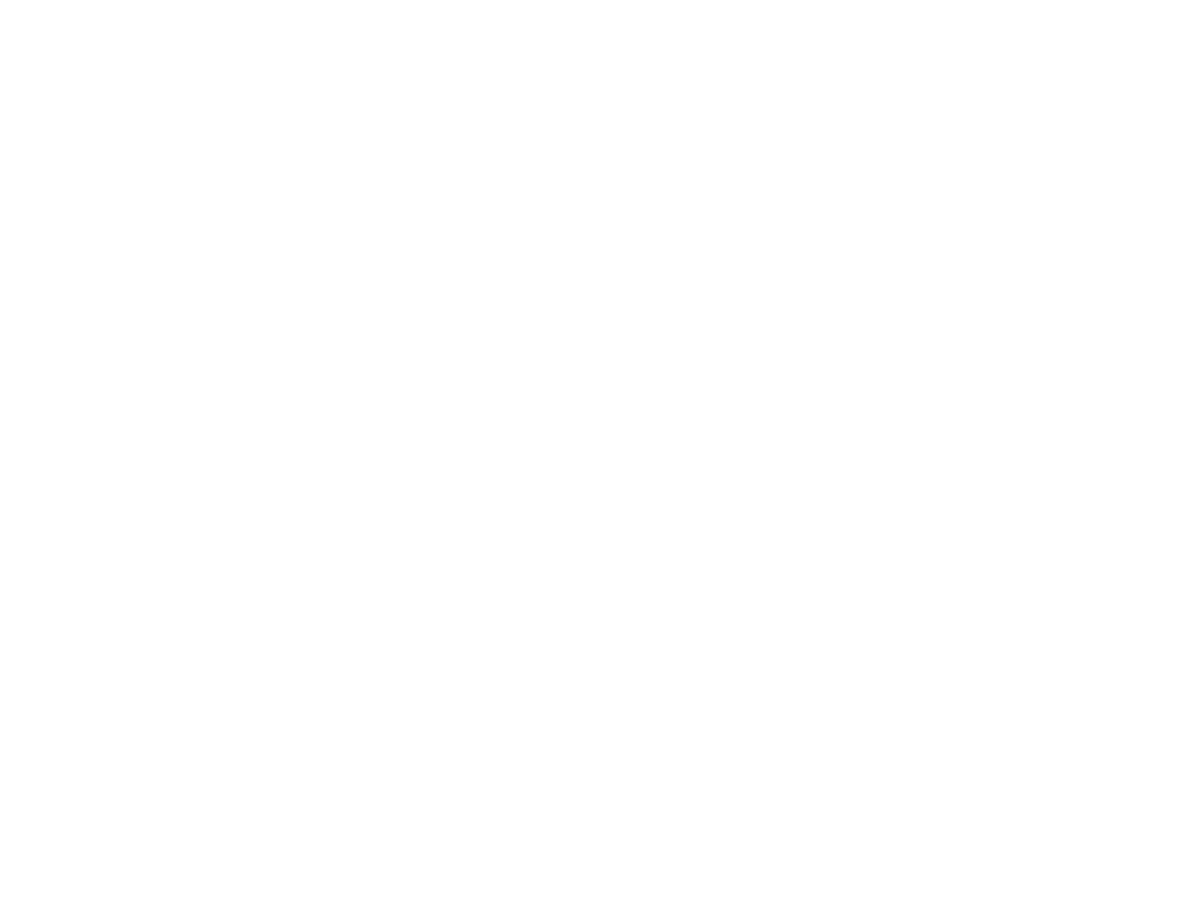

Train score average = 0.7366316316316314
Test score average = 0.7202202202202203


In [8]:
# Generate data and verify graphically that the two classes overlap 
plt.close()
X_overlap,y_overlap = rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[0.5, 1], sigmas1=[0.3, 0.3],sigmas2=[0.3, 0.3])
plot_2d(X_overlap,y_overlap)
X_train_overlap, X_test_overlap, y_train_overlap, y_test_overlap = train_test_split(X_overlap,y_overlap, test_size = 0.25)

# Find the best working C with a 5-fold cross-validation
param_grid = {'C':np.arange(1,1000,1)}
clf_overlap = GridSearchCV(clf, param_grid, return_train_score=True)
clf_overlap.fit(X_train_overlap,y_train_overlap)
clf_overlap.best_params_ 
print('Train score average =', np.mean(clf_overlap.cv_results_['mean_train_score']))
print('Test score average =', np.mean(clf_overlap.cv_results_['mean_test_score']))

**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore gamma and C), can lead to overfitting.

In [9]:
# Vary the parameter of the kernel and check the difference between training and testing scores
clf_overlap_gauss = SVC(kernel = 'rbf')
param_gauss = {'C':np.arange(1,1000,1), 'gamma' : [0.0001,0.001,0.01,0.1]} #On fait varier les valeurs de gamma en ajoutant ou retirant des valeurs ici
clf_overlap_gauss = GridSearchCV(clf_overlap_gauss, param_gauss, return_train_score= True)
clf_overlap_gauss.fit(X_overlap,y_overlap)
mean_train = clf_overlap_gauss.cv_results_['mean_train_score']
mean_test = clf_overlap_gauss.cv_results_['mean_test_score']
print('Difference between the mean testing and training score : ', np.mean(mean_train-mean_test))
print('Best C to choose =' ,clf_overlap_gauss.best_params_['C'])
print('Best gamma to choose =' ,clf_overlap_gauss.best_params_['gamma'])

Difference between the mean testing and training score :  0.020846784284284253
Best C to choose = 133
Best gamma to choose = 0.0001


We get an extremely low error between the testing and training score which could lead us to think that we are overfitting the model.

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function make_blobs available in sklearn.datasetslibrary ).

<IPython.core.display.Javascript object>


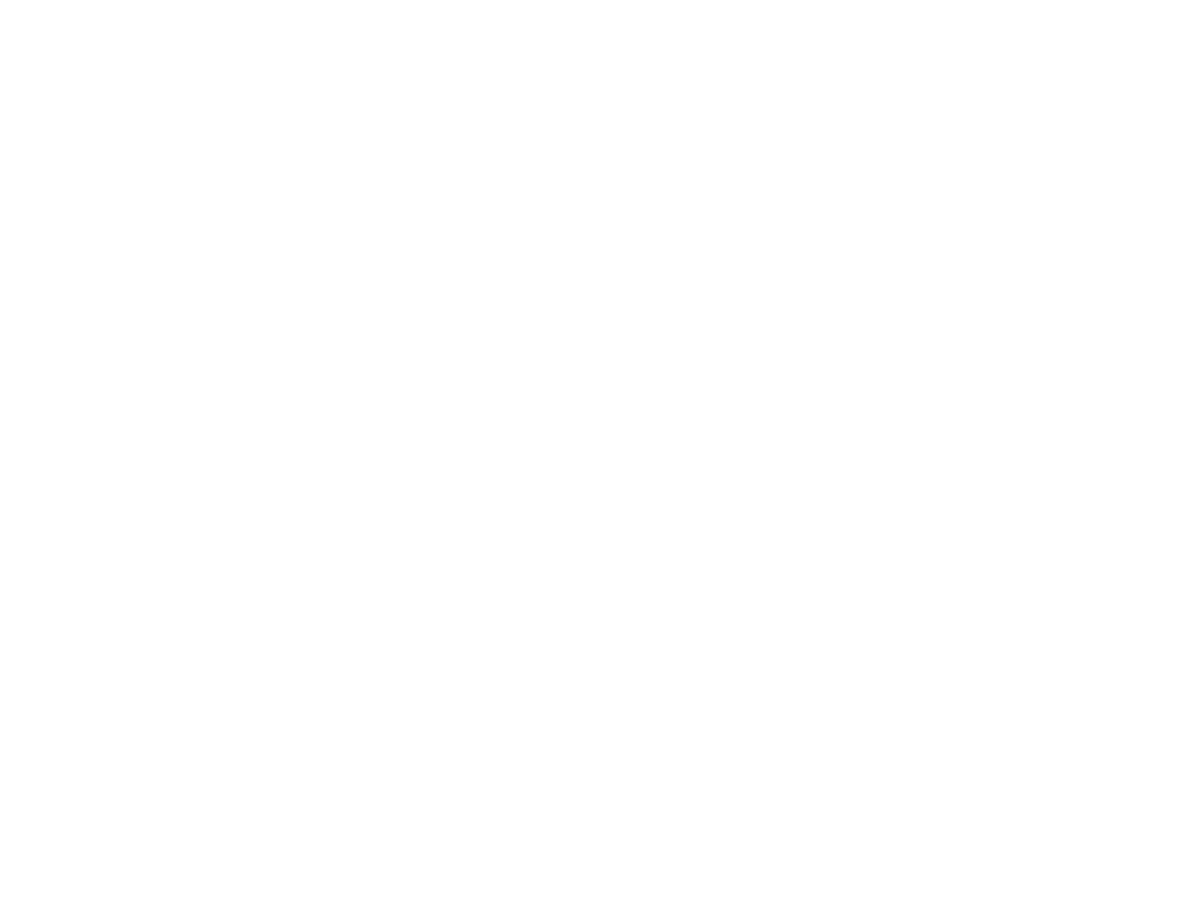

In [10]:
plt.close()
X_1, y_1 = make_blobs(centers = 2, cluster_std= (10,0.1), center_box=(0,0))
plot_2d(X_1, y_1)

X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size = 0.25)

**9)** Use an SVM with a Gaussian kernel then a polynomial (with well-adapted parameters) then plot the decision boundaries of these algorithms on separate graphs.

<IPython.core.display.Javascript object>


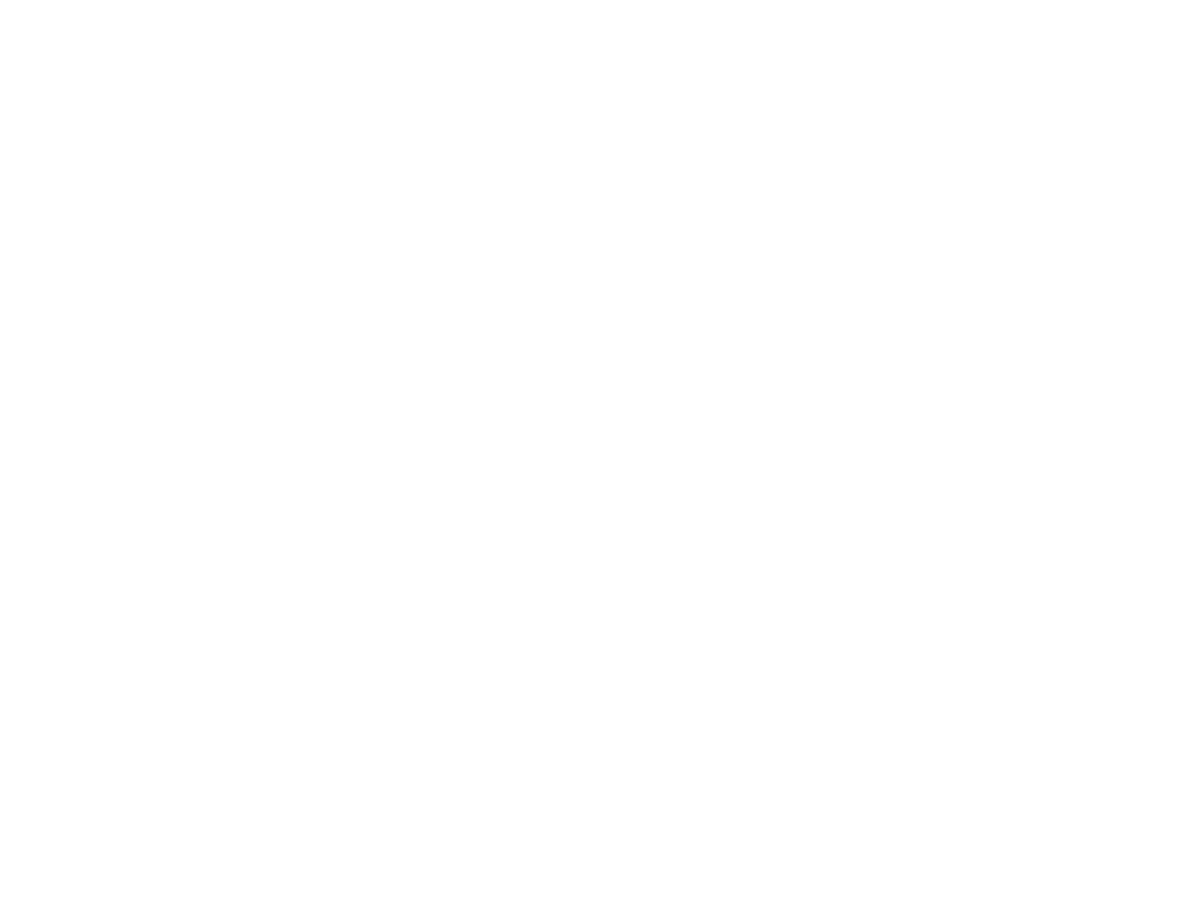

In [11]:
plt.close()
## Gaussian Kernel : 

clf = svm.SVC(kernel= 'rbf', C = 1000)
clf.fit(X_1_train,y_1_train)
plt.scatter(X_1_train[:, 0], X_1_train[:, 1], c=y_1_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

<IPython.core.display.Javascript object>


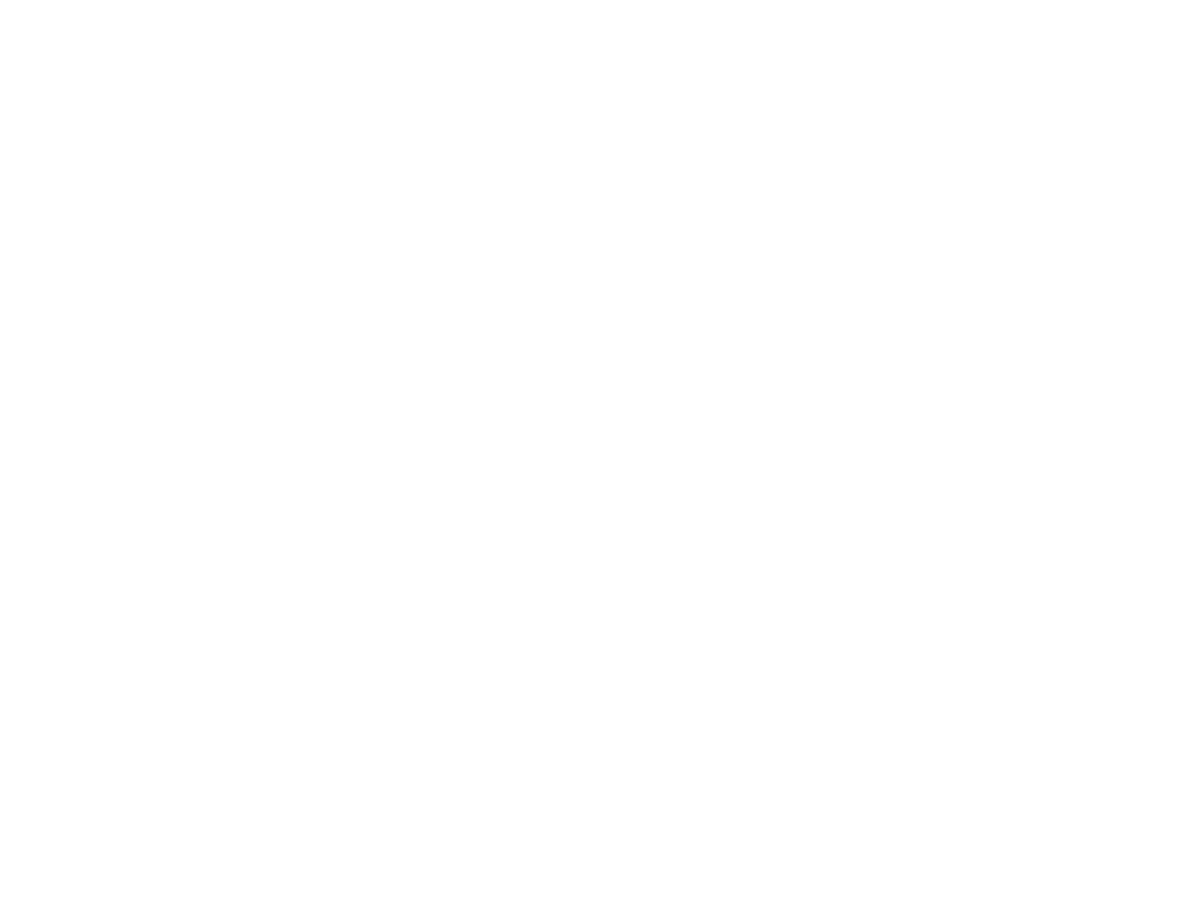

In [12]:
plt.close()
## Polynomial Kernel : 
clf = svm.SVC(kernel= 'poly', C = 1000 ,degree=5)
clf.fit(X_1_train,y_1_train)
plt.scatter(X_1_train[:, 0], X_1_train[:, 1], c=y_1_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

<IPython.core.display.Javascript object>


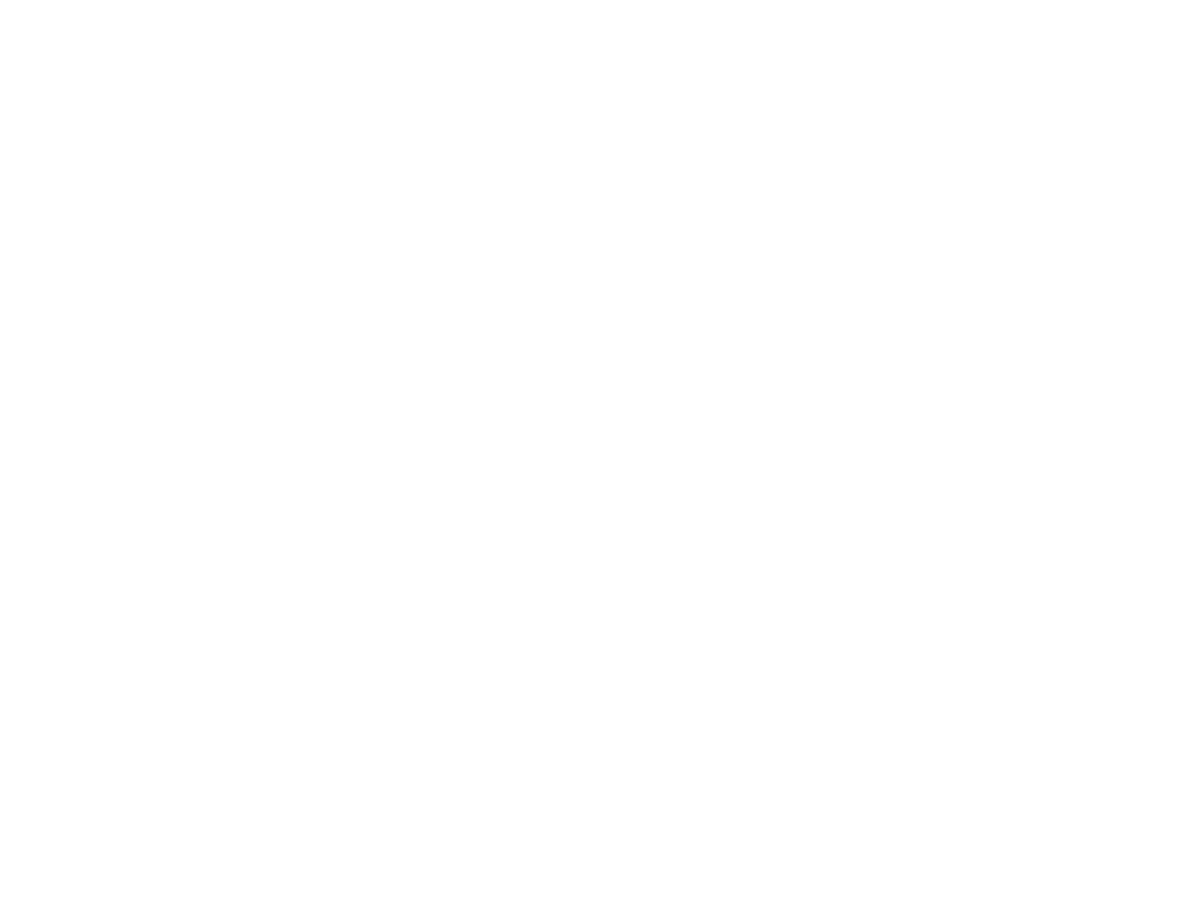

In [13]:
plt.close()
## Polynomial Kernel : 
clf = svm.SVC(kernel= 'poly', C = 1000 ,degree=10)
clf.fit(X_1_train,y_1_train)
plt.scatter(X_1_train[:, 0], X_1_train[:, 1], c=y_1_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

<IPython.core.display.Javascript object>


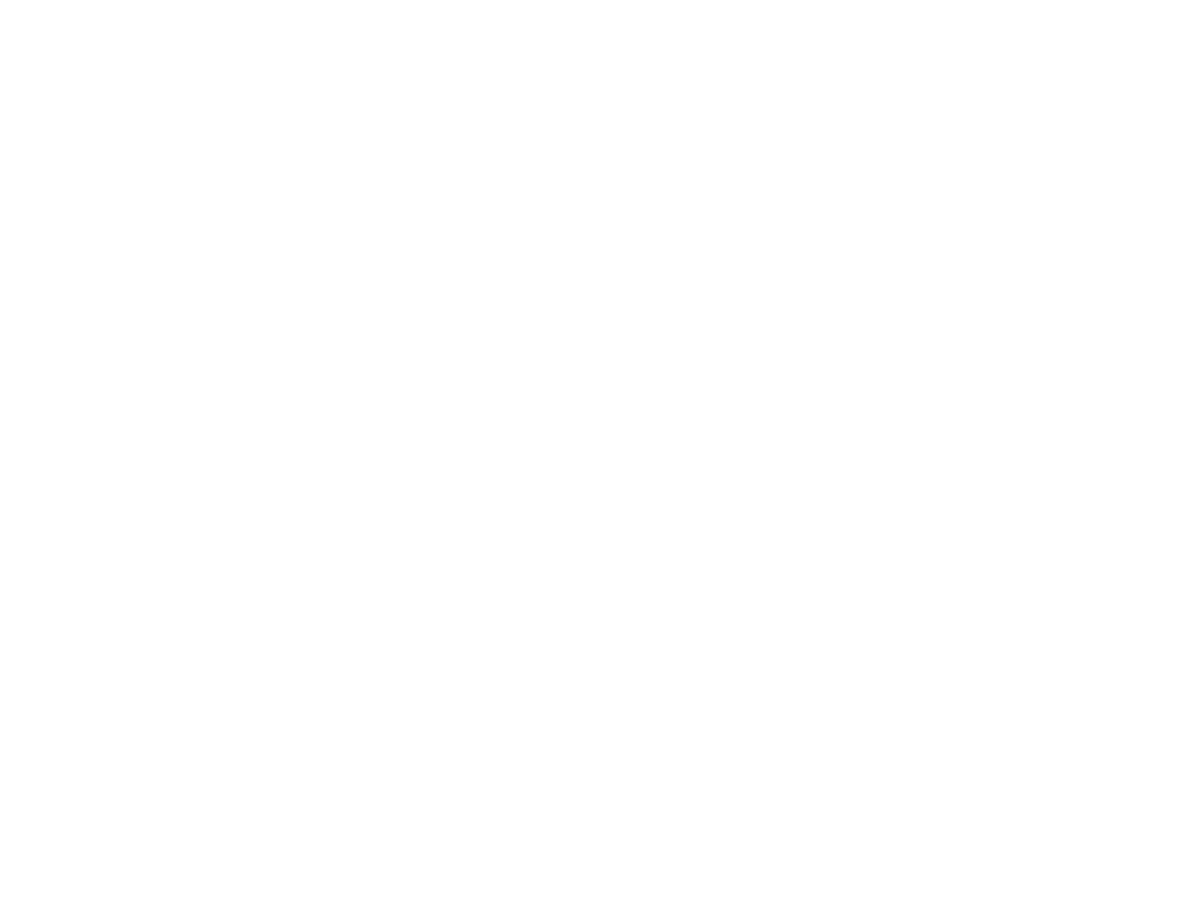

In [14]:
plt.close()
## Polynomial Kernel : 
clf = svm.SVC(kernel= 'poly', C = 1000 ,degree=100)
clf.fit(X_1_train,y_1_train)
plt.scatter(X_1_train[:, 0], X_1_train[:, 1], c=y_1_train, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

The more we increase the degree of the polynomial, the more likely we are to overfit if our number of points is about the same
as the degree of the interpolator. We also may notice that when the degree of the polynomial interpolator is odd we get a spiderweb and with an even number we get a delimiter like a circle/square.

**10)** We wish to compare classification performance between different SVMs based on different kernels
(linear, polynomial and Gaussian). Propose a method allowing to compare these three algorithms.

In order to compare classification performance between our SVMs , we can for example choose different values for our parameters,
and look out for the method with the highest average score. For example we change the value of C we apply a 5-fold cross 
validation to look for the best score in estimating our last fold, then we may try to change the degree for the polynomial
kernel interpolation and the value of gamma as shown previously. Any kind of cross validation could help us in the choice of the hyperparemeters for each method and find the optimal parameters for each method then we compare each method's complexity and accuracy to finally choose the best settings to study our data.

**11)** Draw the learning curve of the algorithm : with fixed hyper-parameters and fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

<IPython.core.display.Javascript object>


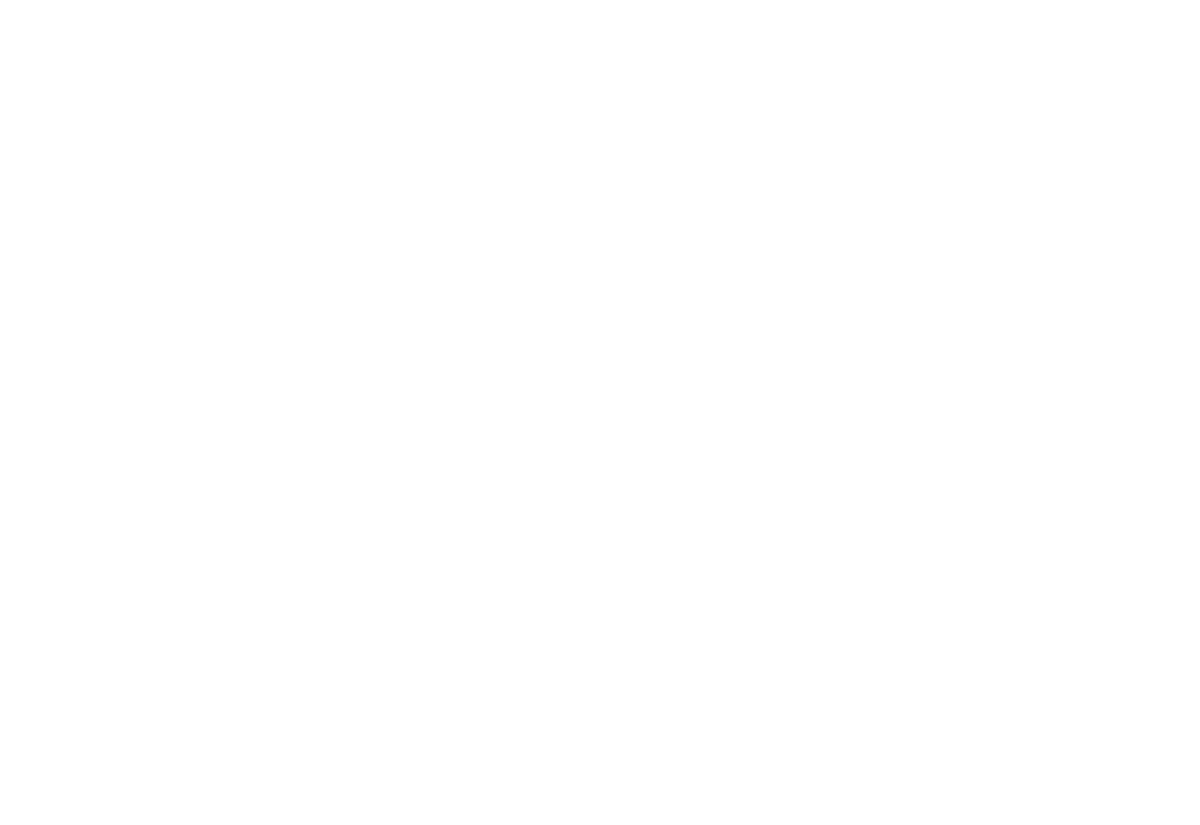

(0.0, 10.0)

In [15]:
#Plot of the learning curves with a linear regression model
plt.close()
train_sizes = []
N=100
for i in range(N):
    train_sizes.append(rd.random())

train_sizes, train_scores, validation_scores = learning_curve(estimator = LinearRegression(),X = X_1, y = y_1, train_sizes = train_sizes, cv = 5,scoring = 'neg_mean_squared_error')
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves with a linear regression model', fontsize = 18)
plt.legend()
plt.ylim(0,10)

In [16]:
#Display of the average training/validation scores
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1    -0.000000e+00
2    -0.000000e+00
3     3.257009e-29
4     1.062141e-01
7     1.176769e-01
8     1.627818e-01
10    1.409338e-01
11    2.411778e-01
13    2.256533e-01
14    2.216161e-01
16    2.093364e-01
17    2.206818e-01
18    2.360223e-01
19    2.401686e-01
21    2.394560e-01
22    2.412708e-01
24    2.438014e-01
29    2.433761e-01
30    2.426009e-01
31    2.413958e-01
32    2.391664e-01
33    2.354657e-01
35    2.347001e-01
36    2.335960e-01
38    2.367703e-01
39    2.398838e-01
40    2.405949e-01
41    2.391905e-01
42    2.375381e-01
43    2.383450e-01
47    2.407659e-01
48    2.400791e-01
49    2.380735e-01
50    2.390671e-01
51    2.397035e-01
52    2.395663e-01
53    2.394608e-01
54    2.387659e-01
55    2.392742e-01
56    2.408745e-01
57    2.410426e-01
58    2.427739e-01
59    2.429180e-01
60    2.441216e-01
61    2.442890e-01
62    2.449238e-01
63    2.455548e-01
67    2.463647e-01
68    2.464427e-01
70    2.465322e-01
71    2.469594e-01
72    2.

In [17]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)

n= 1000
mu = [[X_1[:,0].mean(),X_1[:,1].mean()], [y_1[:,].mean(),y_1[:,].mean()]]

mc_0 = np.random.multivariate_normal(mu[0], np.eye(2), n//2)
mc_1 = np.random.multivariate_normal(mu[1], 10*np.eye(2), n//2)
MC = np.concatenate((mc_0,mc_1), axis = 0)

bayes_mean = 0 
for c in MC:
    prob_0 = multivariate_normal.pdf(c, mu[0], cov=np.eye(2))
    prob_1 = multivariate_normal.pdf(c, mu[1], cov=np.eye(2))
    bayes_risk = min(prob_0/(prob_0+prob_1), prob_1/(prob_0+prob_1))
    bayes_mean += (1/n)*bayes_risk
    
print('Estimation of the Bayes Risk =', bayes_mean)

Estimation of the Bayes Risk = 0.34578405459397454


**12)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.


<IPython.core.display.Javascript object>


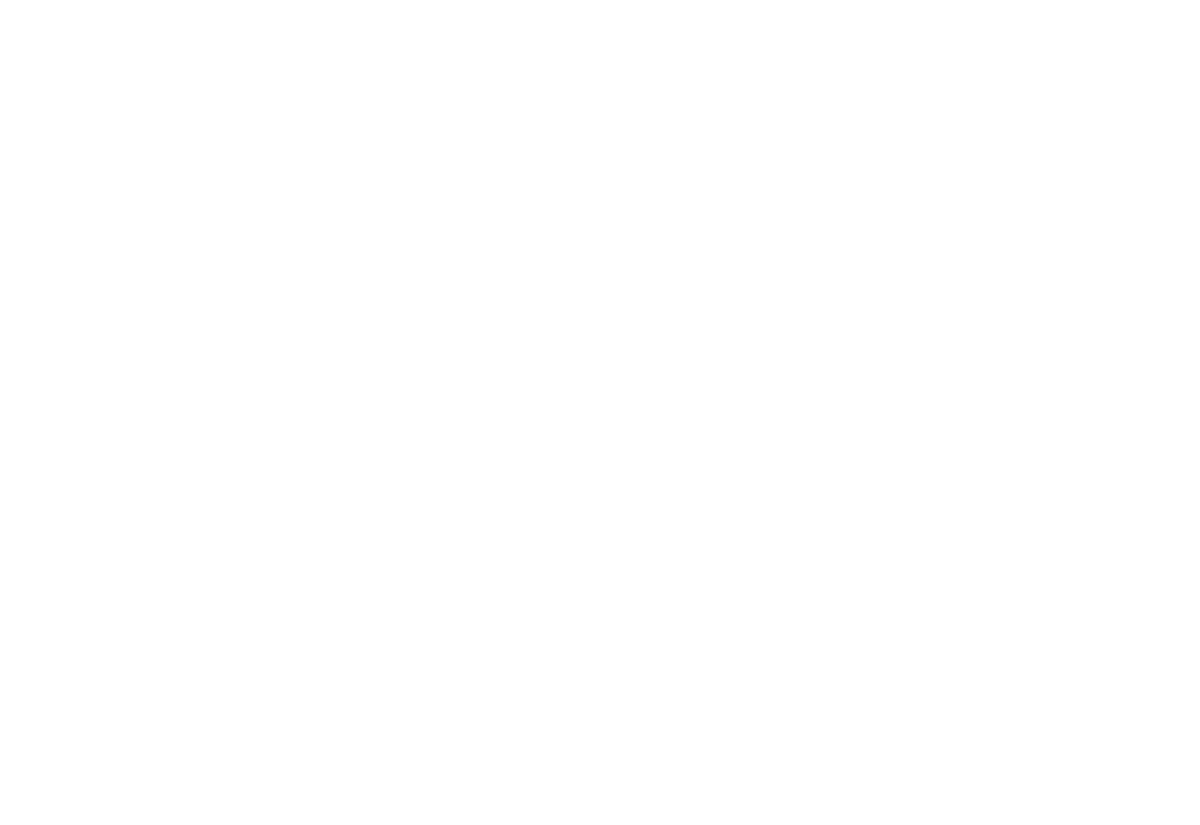

In [18]:
# Modify the class of some data points randomly
plt.close()

X_1, y_1 = make_blobs(centers = 2, cluster_std= (10,0.1), center_box=(0,0))
y_1[y_1==2] = 1
n_noise = 50
n_tr = len(y_1_train)
idx = np.random.choice(range(n_tr), n_noise)
y_1[idx] = 1- y_1[idx]
pos = np.where(y_1==1)[0]
neg = np.where(y_1==0)[0]

plt.scatter(X[pos,0],X[pos,0],c='r')
plt.scatter(X[neg,0],X[neg,1],c='b')

plt.axis('equal')
plt.show()

In [19]:
#Make sure we have the right lengths
print(len(X[pos,0]))
print(len(X[pos,1]))
print(len(X[neg,0]))
print(len(X[neg,1]))

53
53
47
47


## SVM GUI

**13)** Start the script svm_gui.py available at the link : http://scikit-learn.org/stable/auto_
examples/applications/svm_gui.html
This application allows real-time evaluation of the impact the choice of the kernel and the regula-
rization parameter C.

In [ ]:
%run svm_gui.py


Libsvm GUI

A simple graphical frontend for Libsvm mainly intended for didactic
purposes. You can create data points by point and click and visualize
the decision region induced by different kernels and parameter settings.

To create positive examples click the left mouse button; to create
negative examples click the right button.

If all examples are from the same class, it uses a one-class SVM.




**14)** Generate a very unbalanced data set with much more points in one class than in the other (at least
90% vs 10%)

In [ ]:
plt.close()
X_1, y_1 = make_blobs(centers = 2, cluster_std= (10,0.1), center_box=(0,0))

X_u1, X_u2, y_u1, y_u2 = train_test_split(X_1, y_1, test_size = 0.1)
plot_2d(X_u1, y_u1)

In [ ]:
plt.close()
plot_2d(X_u2, y_u2)

**15)** Using a linear kernel and decreasing the parameter C what do you observe ?

The margin shifts to the class with the fewest points to the point that we will get a bad classification of our data if we decrease C too much. To solve this problem we can add weights to our points of the red class which is minority to shift the margin and avoid classifying black dots in the red dots zone. By giving more weights to our minority we say that what matters is our classification problem, we want to know for a given point which does he belong to.

> C = 1
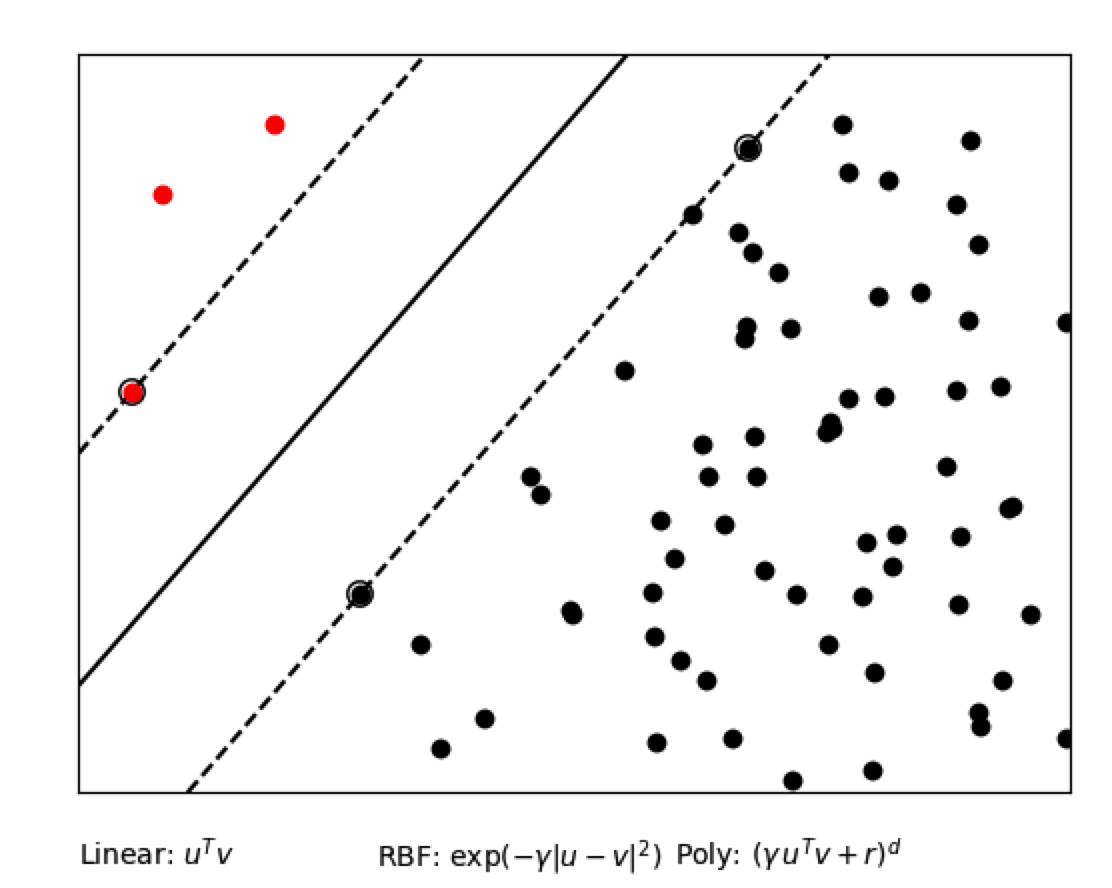

> C = 0.001
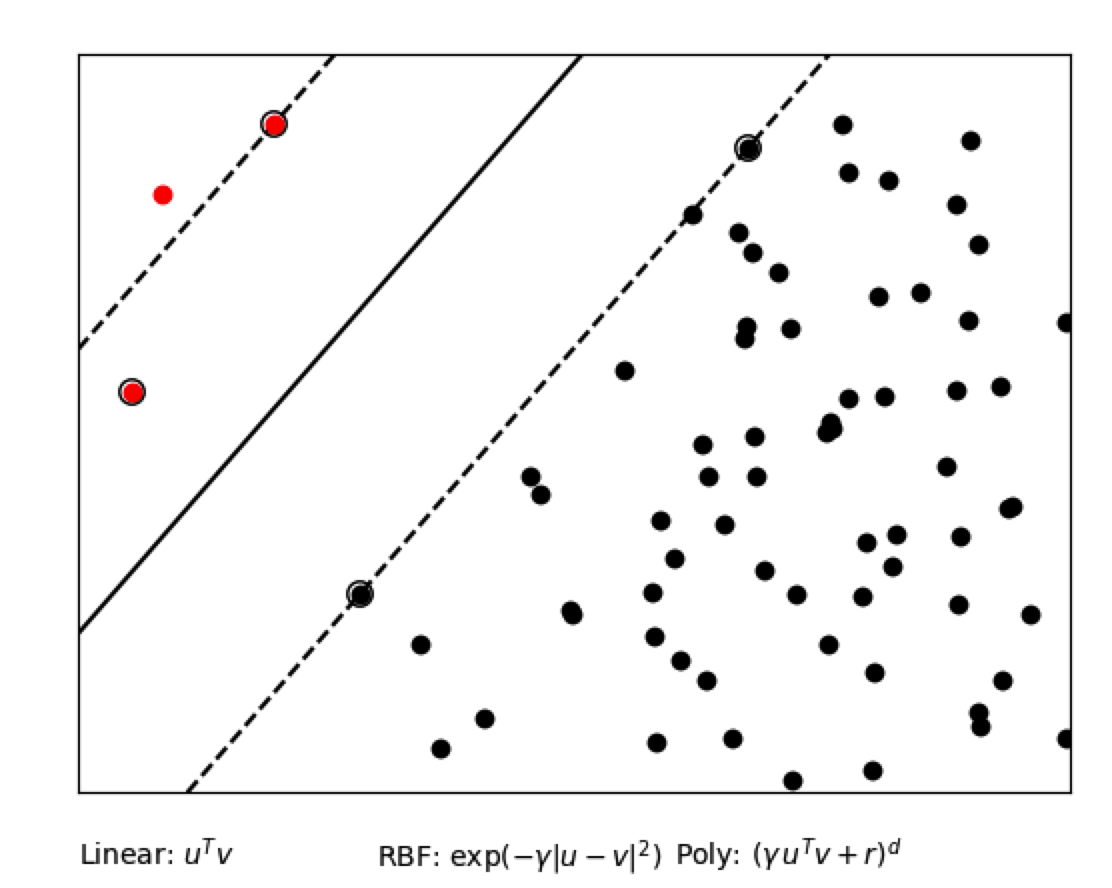

> C = 0.00001
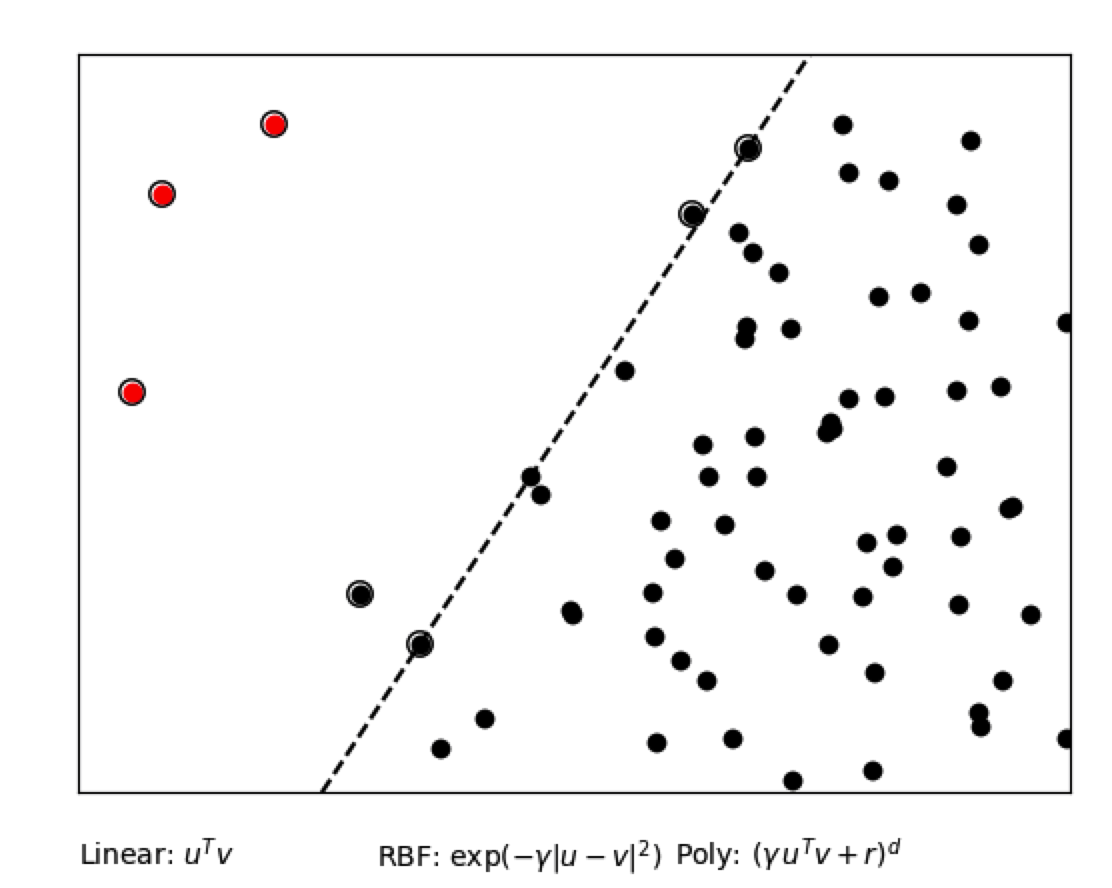


## Going further : application to face classification

Code for downloading and organizing the data:

In [ ]:
plt.close()
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images / 255.
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**16)** By modifying the followind code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of C on a logarithmic scale between 1e5 and 1e-5.

In [ ]:
####################################################################
# Quantitative evaluation of the model quality on the test set
plt.close()
print("Fitting the classifier to the training set")
t0 = time()

C_list = [a*10**b for b in range(-5,5) for a in range(1,9)]
score_list = []
for c in C_list:
    clf = svm.SVC(kernel="linear", C = c)
    clf.fit(X_train, y_train)
    score_list.append(clf.score(X_train, y_train))
    
plt.plot(C_list,score_list)
plt.title("Influence of the regularization parameter")
plt.xscale('log')
plt.ylabel('Score')
plt.xlabel('Value of C')
plt.show()

In [ ]:
print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

In [ ]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib
plt.close()

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**17)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

**18)** Explain why the features are centered and reduced.

We center and reduce the feature because the SVM is not scale invariant thus if we don't normalize our data we could get different classifications for the same repartition of the points even though only our scales, the distance between the points changed and not our classes. Thus to obtain meaningful and logical results we need to rescale our data.

**19)** What is the effect of choosing a non-linear RBF kernel on prediction? You will be able to improve the prediction with a reduction of dimension based on the object sklearn.decomposition.RandomizedPCA.

In [ ]:
plt.close()
k,K = (-2,2)
num_points  = 30

C_ = np.logspace(k, K, num = num_points)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

clf_face_rbf = GridSearchCV(SVC(C=1), {'C':C_, 'kernel':['rbf']}, n_jobs=2)
clf_face_rbf.fit(X_train, y_train)

error = 100*(1-clf_face_rbf.cv_results_['mean_test_score'])
    
ax = plt.gca()
ax.scatter(C_, error)
ax.set_xscale('log')
ax.set_xlim(np.min(C_)/2, np.max(C_)*2)
plt.title("Influence of the penalty parameter over the percentage of error")
plt.xlabel("Penalty parameter")
plt.ylabel("Percentage of error")
plt.show()


In [ ]:
from sklearn.decomposition import PCA

(min_err,min_c,min_i,min_step)  = (100,-1,-1,0) #Initialisation

for i in range(2,100,5):
    print ("\n")
    print ('Step',i//5)
    pca = PCA(n_components=i)

    print("Dimension before PCA: ",X.shape)
    X_pca = pca.fit_transform(X)
    print("Dimension after PCA: ",X_pca.shape)

    # Scale features
    X_pca -= np.mean(X_pca, axis=0)
    X_pca /= np.std(X_pca, axis=0)

    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25)

    clf_pca = GridSearchCV(SVC(C=1), {'C':np.logspace(k, K, num=points), 'kernel':['rbf']}, n_jobs=2)
    clf_pca.fit(X_train, y_train)

    C_ = [param['C'] for param in clf_pca.cv_results_['params']]
    
    error = 100 *(1-clf_pca.cv_results_['mean_test_score'])
    print("Minimal error = ", (np.min(error)))
    
    if(np.min(error) < min_err):
        (min_err,min_i,min_c,min_step) = (np.min(error),i,clf_pca.best_params_['C'],i//5)

print("\nLowest error found when our dimension is reduced to %s features, with C = %s and the error = %s%% revealed at step %s" % (min_i, min_c, min_err,min_step))

The Kernel Trick helps us to actually visualize the non-linear datasets which are more complex and cant be solved or classified on the basis of a linear line. sklearn.decomposition.RandomizedPCA uses a principal component analysis (PCA) using randomized SVD (singular vector decomposition). By this operation, we keep the highest eigenvalues in order to keep less features but the most decisive and thus reduce the dimension of our dataset while keeping a good error.